# Does replaying the same movie clip reduce the variability of resting-state fMRI?

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from pathlib import Path
from bids import BIDSLayout, BIDSLayoutIndexer

#Define filtering parameters
metric = "correlation"
atlas_dimension = "64"
fd_threshold = 0.4
fdthresh_str = str(fd_threshold).replace(".", "")

# Define paths
code_path = Path("/data/code/hcph-sops/")
fc_path = Path(f"/data/derivatives/hcph-derivatives-rsmovie/functional_connectivity/sub-001")
dataset_path = Path("/data/datasets/hcph-dataset")
save_path = code_path / "docs/assets/images"

## Load the functional connectivity matrices

3
2
(2080, 2)


/usr/local/fsl/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/fsl/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/fsl/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/fsl/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected 

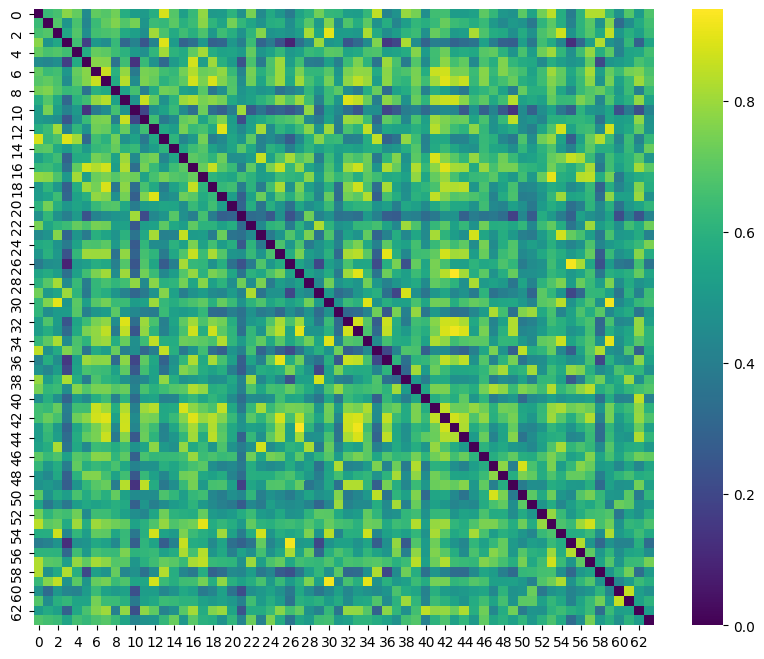

In [19]:
# Initialize the BIDS layout, we use a custom indexer because we are using entities that are not yet officially recognized by BIDS 
config_path = code_path / "code/bids/indexer.json"
_indexer = BIDSLayoutIndexer(
    config_filename="../../code/bids/indexer.json",
    index_metadata=False,
    validate=False,
)       
layout = BIDSLayout(fc_path, indexer=_indexer, validate=False)

# Get all the files matching the pattern
files = layout.get(subject='001', task='rsmovie', suffix='connectivity', extension='tsv', return_type='file')

# Meas is not a recognized entity by PyBIDS, so I am filtering for meas-connectivity separately
# Keep only files with the correct metric, FD threshold and atlas dimension in the filename
files = [f for f in files if f"meas-{metric}" in f]
files = [f for f in files if f"scale-{atlas_dimension}" in f]
files = [f for f in files if f"fdthresh-{fdthresh_str}" in f]
#assert len(files) == 36, f"Expected 36 FC matrices, got {len(files)}"

# Load the data from each file and concatenate
# Keep only upper-triangle since the FC matrix is symmetric (does the diagonal of our FC contain only ones ? if yes can discard the diagonal, if not have to keep it 
fc_matrices = []
for file in files:
    fc_matrix = pd.read_csv(file, sep='\t', header=None)
    fc_matrices.append(fc_matrix.values[np.triu_indices_from(fc_matrix, k=0)])

# Store the matrix size for reconstruction later
fc_size = fc_matrix.shape[0]
# Concatenate all the upper triangle values
fc_concat = np.vstack(fc_matrices)
# Transport matrix
fc_concat = fc_concat.T

#Plot an example FC matrix
plt.figure(figsize=(10, 8))
sns.heatmap(fc_matrix, cmap='viridis')

# Generate a random matrix of size 2080x36
#fc_concat = np.random.rand(2080, 36)
print(fc_concat.shape)

(2, 2)


/tmp/ipykernel_1030174/1471793901.py:7: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(save_path / 'suppl_fmrivar_similarity_matrix_heatmap.png')
/tmp/ipykernel_1030174/1471793901.py:7: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(save_path / 'suppl_fmrivar_similarity_matrix_heatmap.png')
/tmp/ipykernel_1030174/1471793901.py:7: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(save_path / 'suppl_fmrivar_similarity_matrix_heatmap.png')
/tmp/ipykernel_1030174/1471793901.py:7: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer sup

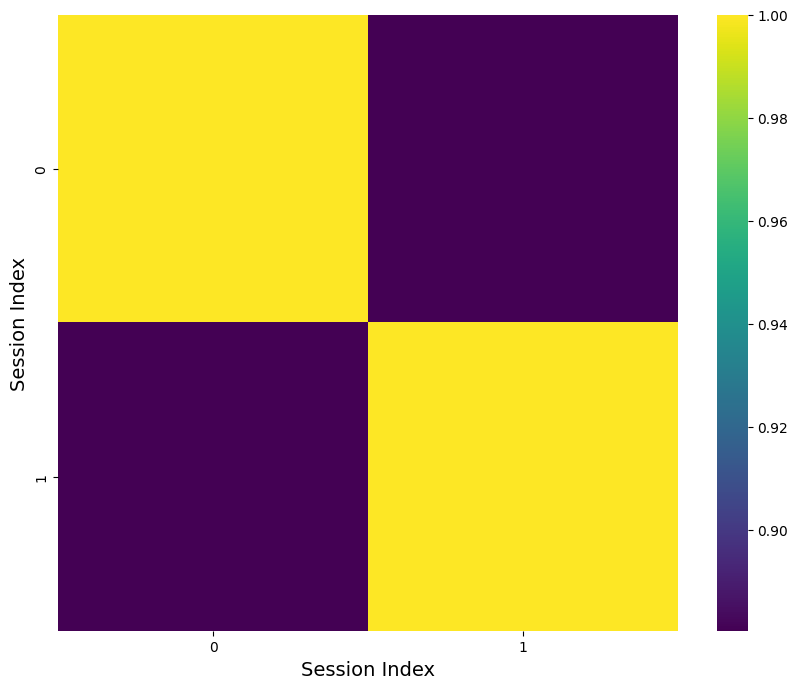

Overall mean correlation: 0.9401739783076779


In [6]:
similarity_matrix = np.corrcoef(fc_concat, rowvar=False)
print(similarity_matrix.shape)
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, cmap='viridis')
plt.xlabel('Session Index', fontsize=14)
plt.ylabel('Session Index', fontsize=14)
plt.show()

mean_corr = np.mean(similarity_matrix)
print(f"Overall mean correlation: {mean_corr}")


## Run PCA to estimate the residual variance for each rsfMRI run

/usr/local/fsl/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/fsl/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/fsl/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/fsl/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected 

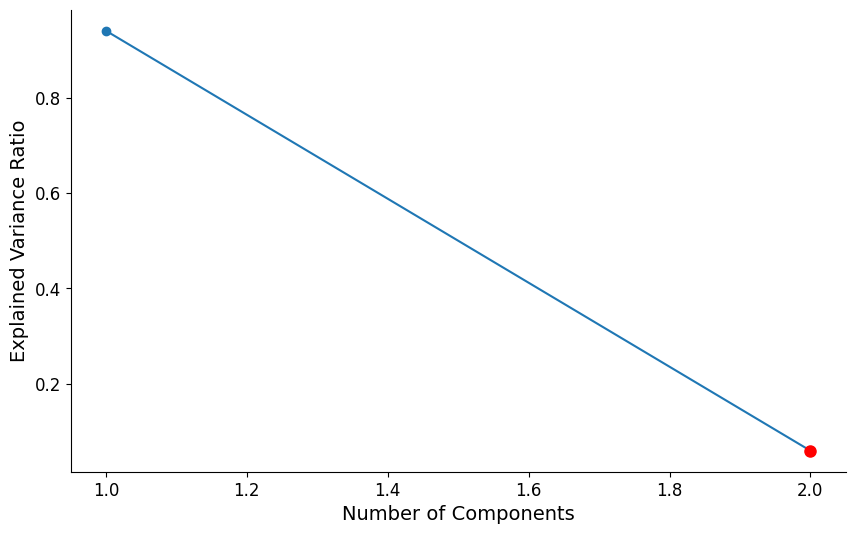

In [7]:
from sklearn.decomposition import PCA

# Run PCA
# Center the data by removing the mean from each session
fc_concat = fc_concat - np.mean(fc_concat, axis=0)

# Standardize the data to have unit variance
fc_concat = fc_concat / np.std(fc_concat, axis=0)

# Run PCA
pca = PCA()
pca.fit(fc_concat)

# Calculate the explained variance
explained_variance = pca.explained_variance_ratio_

# Generate the elbow plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='-')
ax.set_xlabel('Number of Components', fontsize=14)
ax.set_ylabel('Explained Variance Ratio', fontsize=14)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#Define the number of components to keep
n_comp = 2

# Highlight the points corresponding to number of components we keep in red
ax.plot(n_comp, explained_variance[n_comp-1], marker='o', markersize=8, color='red')

plt.show()

We are using the elbow plot to decide the number of principal components to keep.

## Reconstruct the FC with a limited number of components

After extracting the principal components, each FC matrix can be expressed as a linear combinations of the principal components plus a residual matrix.

In [8]:
print(pca.components_.shape)
# Project PC components back into each FC subject space
fc_projected = pca.transform(fc_concat)[:, :n_comp]
print(fc_projected.shape)
fc_reconstructed = np.dot(fc_projected, pca.components_[:n_comp, :]) + np.mean(fc_concat, axis=0)
print(fc_reconstructed.shape)

(2, 2)
(2080, 2)
(2080, 2)


## Compute the residual matrix

In [9]:
# Calculate the residuals as the difference between the full and reconstructed FC matrices
residuals = fc_concat - fc_reconstructed
print(residuals.shape)

(2080, 2)


In [10]:
import numpy as np
from sklearn.decomposition import PCA

# Project the data onto the residual components (from n_comp + 1 onwards)
residuals_frompc = pca.transform(fc_concat)[:, n_comp:]

# Reconstruct the data using the residual components
residuals_frompc = np.dot(residuals_frompc, pca.components_[n_comp:, :]) + np.mean(fc_concat, axis=0)

# Print the shape of the reconstructed data
print(residuals_frompc.shape)

(2080, 2)


## Plot residual matrix

In [11]:
# Function to reconstruct the full matrix from the upper triangle
def reconstruct_full_matrix(upper_triangle, size):
    full_matrix = np.zeros((size, size))
    upper_indices = np.triu_indices(size)
    full_matrix[upper_indices] = upper_triangle
    full_matrix = full_matrix + full_matrix.T - np.diag(np.diag(full_matrix))
    return full_matrix

# Test my reconstruction function
upper_triangle = fc_matrix.values[np.triu_indices_from(fc_matrix, k=0)]
full_matrix = reconstruct_full_matrix(upper_triangle, fc_size)
full_matrix.shape
assert np.array_equal(full_matrix, fc_matrix.values)

/usr/local/fsl/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/fsl/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/fsl/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/fsl/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected 

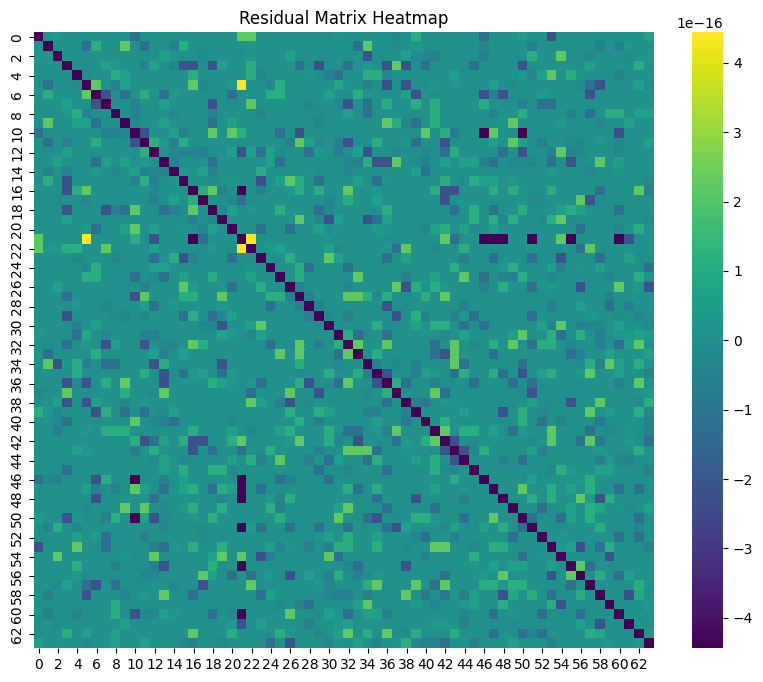

In [12]:
residual = reconstruct_full_matrix(residuals[:,0], fc_size)

# Plot the residual matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(residual, cmap='viridis')
plt.title('Residual Matrix Heatmap')
plt.show()

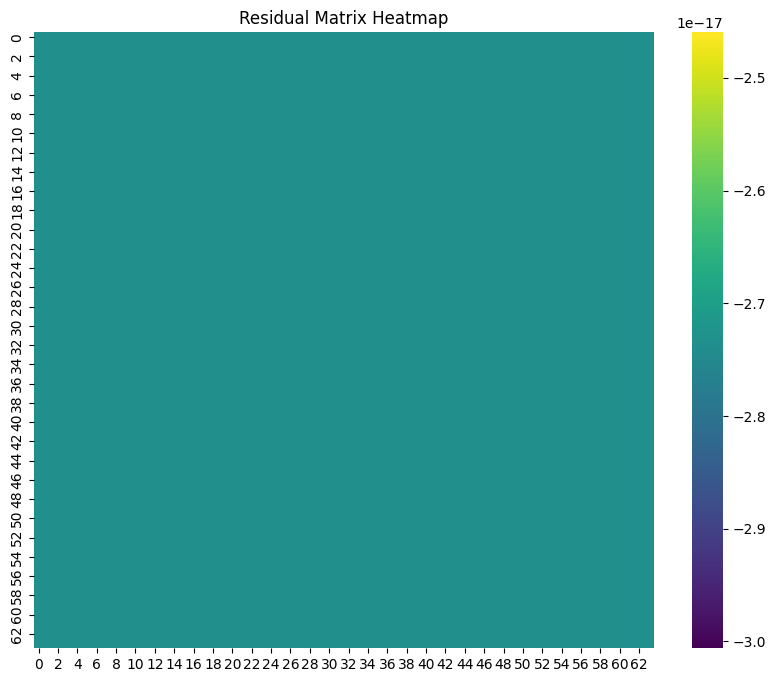

In [13]:
# Check whether reconstructing the residuals a different way leads to the same result
residual_frompc = reconstruct_full_matrix(residuals_frompc[:,0], fc_size)

# Plot the residual matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(residual_frompc, cmap='viridis')
plt.title('Residual Matrix Heatmap')
plt.show()

## Plot the variance of the residuals over sessions

In [14]:
def plot_res_variance(residuals, groupedby=False, min_res_var=0, max_res_var=1000):
    from scipy.optimize import curve_fit
    from sklearn.metrics import r2_score
    
    # Compute the variance of the residuals for each session
    residuals_var = np.var(residuals, axis=0)
    min_res_var = min(min_res_var, min(residuals_var))
    max_res_var = max(max_res_var, max(residuals_var))

    # Plot the variance of the residuals as a function of the session index
    plt.plot(range(len(residuals_var)), residuals_var, marker='o', linestyle='-', label='Variance of Residuals')

    # Fit and plot a negative exponential curve
    def neg_exp(x, a, b, c):
        return a * np.exp(-b * x) + c

    if residuals_var.shape[0] > 3:
        #popt, _ = curve_fit(neg_exp, range(len(residuals_var)), residuals_var, p0=(1, 0.01, 1))
        #neg_exp_r2 = r2_score(residuals_var, neg_exp(range(len(residuals_var)), *popt))
        #plt.plot(range(len(residuals_var)), neg_exp(range(len(residuals_var)), *popt), linestyle='--', label=f'Negative Exponential Fit (R$^2$={neg_exp_r2:.2f})')
        
        # Fit and plot a quadratic curve
        quadratic_model = np.poly1d(np.polyfit(range(len(residuals_var)), residuals_var, 2))
        quadratic_r2 = r2_score(residuals_var, quadratic_model(range(len(residuals_var))))
        plt.plot(range(len(residuals_var)), quadratic_model(range(len(residuals_var))), linestyle='--', label=f'Quadratic Fit (R$^2$={quadratic_r2:.2f})')

    # Fit and plot a linear curve
    linear_model = np.poly1d(np.polyfit(range(len(residuals_var)), residuals_var, 1))
    linear_r2 = r2_score(residuals_var, linear_model(range(len(residuals_var))))
    plt.plot(range(len(residuals_var)), linear_model(range(len(residuals_var))), linestyle='--', label=f'Linear Fit (R$^2$={linear_r2:.2f})')

    plt.tick_params(axis='x', labelsize=12)
    plt.tick_params(axis='y', labelsize=12)
    plt.legend()
    if groupedby:
        plt.title(groupedby, fontsize=16)
        
    return min_res_var, max_res_var
   

In [15]:
# Exclude 30th column
residuals_wo_outlier = np.delete(residuals, 30, axis=1)

plt.figure(figsize=(20, 6))

# Plot with residuals
plt.subplot(1, 2, 1)
plot_res_variance(residuals)
plt.xlabel('Session Index', fontsize=14)
plt.ylabel('Variance of Residuals', fontsize=14)
plt.title('All Sessions', fontsize=16)
#plt.ylim(0.06, 0.24)

# Plot with residuals_wo_outlier
plt.subplot(1, 2, 2)
plot_res_variance(residuals_wo_outlier)
plt.xlabel('Session Index', fontsize=14)
plt.ylabel('Variance of Residuals', fontsize=14)
plt.title('Excluding the Outlier', fontsize=16)
#plt.ylim(0.06, 0.24)

plt.tight_layout()
plt.show()

IndexError: index 30 is out of bounds for axis 1 with size 2

## Plot edgewise residual over sessions

In [73]:
def plot_edgewise_residual(residuals, groupedby=False):
    # Calculate the interquartile range (IQR)
    q1 = np.percentile(residuals, 25, axis=0)
    q3 = np.percentile(residuals, 75, axis=0)

    # Plot the evolution of the residual for each edge
    for i in range(residuals.shape[0]):
        plt.plot(range(residuals.shape[1]), residuals[i,:], color='blue', alpha=0.1)

    # Plot the inter-quartile
    plt.plot(range(residuals.shape[1]), q1, color='orange', label='25th percentile')
    plt.plot(range(residuals.shape[1]), q3, color='orange', label='75th percentile')
    plt.tick_params(axis='x', labelsize=12)
    plt.tick_params(axis='y', labelsize=12)
    plt.legend()
    if groupedby:
        plt.title(groupedby, fontsize=16)

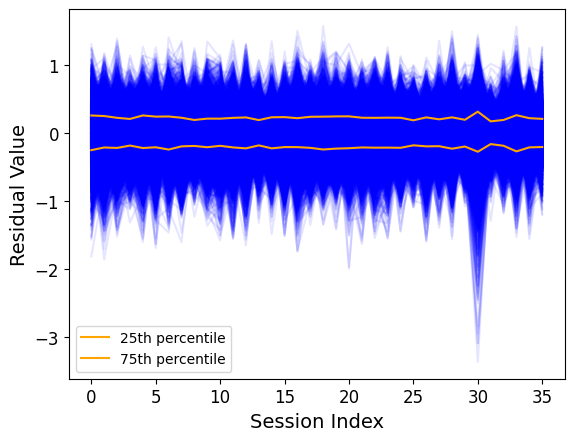

In [74]:
plot_edgewise_residual(residuals)
plt.xlabel('Session Index', fontsize=14)
plt.ylabel('Residual Value', fontsize=14)
plt.show()

#Retrieve confounds

### Retrieve scan time and day of week from the `scans.tsv` in the dataset repo

In [77]:
# Read the scans.tsv file
scans_df = pd.read_csv(dataset_path / "scans.tsv", sep='\t')
scans_df.drop(columns=["randstr"], inplace=True)

#Extract entities
# Each echo and magnitude and phase part of each functional scans are recorded on separate line, 
# but we have only one final image so keep only one of the identical acq_time
scans_df = scans_df.drop_duplicates(subset=["acq_time"])
scans_df = scans_df.assign(
    subject=scans_df["filename"].str.extract(r"sub-(\d+)/"),
    session=scans_df["filename"].str.extract(r"ses-(\w+)/"),
    modality=scans_df["filename"].str.split("/").str[2],
    task=scans_df["filename"].str.extract(r"task-(\w+)_"),
    pe_dir=scans_df["filename"].str.extract(r"dir-(\w+)_"),
)
# Keep only the magnitude part of functional scans and first echo
scans_df = scans_df[scans_df["modality"] == "func"]

# Create dataframe based on the list of files
files_df = pd.DataFrame(files, columns=['file_path'])
files_df = files_df.assign(
    subject=files_df["file_path"].str.extract(r"sub-(\d+)/"),
    session=files_df["file_path"].str.extract(r"ses-(\w+)/"),
    task=files_df["file_path"].str.extract(r"task-(\w+)_"),
)

#Pair filenames with acquisition time
confounds_df = pd.merge(
        scans_df, files_df, on=["subject", "session", "task"], how="inner"
    )
confounds_df.drop(columns=["file_path"], inplace=True)

# From the acq_time column, extract the day of week and time of day
confounds_df = confounds_df.assign(datetime = pd.to_datetime(confounds_df["acq_time"]))
confounds_df = confounds_df.assign(
    day_of_week = confounds_df['datetime'].dt.day_name(),
    time_of_day = confounds_df['datetime'].dt.round('H').dt.time
)
confounds_df.drop(columns=["datetime"], inplace=True)
print(confounds_df.head())


                                            filename  \
0  sub-001/ses-001/func/sub-001_ses-001_task-rsmo...   
1  sub-001/ses-003/func/sub-001_ses-003_task-rsmo...   
2  sub-001/ses-004/func/sub-001_ses-004_task-rsmo...   
3  sub-001/ses-005/func/sub-001_ses-005_task-rsmo...   
4  sub-001/ses-006/func/sub-001_ses-006_task-rsmo...   

                     acq_time subject session modality     task pe_dir  \
0  2023-10-20T19:50:01.187500     001     001     func  rsmovie     LR   
1  2023-10-21T10:12:32.207500     001     003     func  rsmovie     LR   
2  2023-10-21T12:22:08.222500     001     004     func  rsmovie     RL   
3  2023-10-22T10:33:53.380000     001     005     func  rsmovie     PA   
4  2023-10-22T12:18:06.200000     001     006     func  rsmovie     PA   

  day_of_week time_of_day  
0      Friday    20:00:00  
1    Saturday    10:00:00  
2    Saturday    12:00:00  
3      Sunday    11:00:00  
4      Sunday    12:00:00  


### Retrieve coffee consumption from the issues in the GitHub repository of confound collection

In [78]:
""" # GitHub repository details
repo_owner = 'TheAxonLab'  # Replace with your GitHub username or org name
repo_name = 'hcph-mood-quest'
# Read token from token.txt
with open('/home/cprovins/token.txt', 'r') as file:
    token = file.read().strip()

# GitHub API headers
headers = {
    'Authorization': f'token {token}',
    'Accept': 'application/vnd.github.v3+json'
}

# Regular expression to match issue titles with the optional [BEFORE] tag and confounds of interest
issue_title_pattern = r'\[MOOD\](?:\[BEFORE\])? sub-001_ses-0\d{2}'
caffeine_2h_pattern = r'### Caffeine intake in the last 2h \(# cups\)\s+(\d+)'
caffeine_24h_pattern = r'### Caffeine intake in the last 24h \(# cups\)\s+(\d+)'

def get_confounds_in_issues():
    data = []
    page = 1

    while True:
        url = f'https://api.github.com/repos/{repo_owner}/{repo_name}/issues'
        params = {'state': 'all', 'per_page': 100, 'page': page}
        response = requests.get(url, headers=headers, params=params)
        issues = response.json()
        print(issues)
        
        # Stop if no more issues
        if not issues:
            break

        for issue in issues:
            title = issue['title']
            if re.search(issue_title_pattern, title):
                # Get the issue body
                issue_body = issue['body']

                # Extract scan time, and confounds of interest
                caffeine_2h = re.search(caffeine_2h_pattern, issue_body)
                caffeine_24h = re.search(caffeine_24h_pattern, issue_body)
                
                data.append({
                    'IssueTitle': title,
                    'CaffeineIntake2h': int(caffeine_2h.group(1)) if caffeine_2h else None,
                    'CaffeineIntake24h': int(caffeine_24h.group(1)) if caffeine_24h else None
                })
        
        page += 1

    return pd.DataFrame(data)

# Retrieve scan times
coffee_df = get_confounds_in_issues()

print(confounds_df) """

" # GitHub repository details\nrepo_owner = 'TheAxonLab'  # Replace with your GitHub username or org name\nrepo_name = 'hcph-mood-quest'\n# Read token from token.txt\nwith open('/home/cprovins/token.txt', 'r') as file:\n    token = file.read().strip()\n\n# GitHub API headers\nheaders = {\n    'Authorization': f'token {token}',\n    'Accept': 'application/vnd.github.v3+json'\n}\n\n# Regular expression to match issue titles with the optional [BEFORE] tag and confounds of interest\nissue_title_pattern = r'\\[MOOD\\](?:\\[BEFORE\\])? sub-001_ses-0\\d{2}'\ncaffeine_2h_pattern = r'### Caffeine intake in the last 2h \\(# cups\\)\\s+(\\d+)'\ncaffeine_24h_pattern = r'### Caffeine intake in the last 24h \\(# cups\\)\\s+(\\d+)'\n\ndef get_confounds_in_issues():\n    data = []\n    page = 1\n\n    while True:\n        url = f'https://api.github.com/repos/{repo_owner}/{repo_name}/issues'\n        params = {'state': 'all', 'per_page': 100, 'page': page}\n        response = requests.get(url, headers=

# Plot residuals grouped by bins of confound factor

In [79]:
# Merge residuals with confounds_df to get the time_of_day for each session
residuals_df = pd.DataFrame(residuals.T)
residuals_df = residuals_df.assign(
    session = files_df['session'],
)
residuals_df = pd.merge(residuals_df, confounds_df[['session', 'day_of_week', 'time_of_day','pe_dir']], on='session')
print(residuals_df.shape)
print(residuals_df.head())

(36, 8260)
          0         1         2         3         4         5         6  \
0 -0.303379  0.669115 -0.145182 -0.305314  0.513179  0.182868 -0.493812   
1 -0.180046  0.064673  0.123993  0.253769  0.076047  0.549303  0.090819   
2 -0.035071  0.531033 -0.377085 -0.498232 -0.237952  0.063948 -0.097563   
3 -0.155283  0.504758 -0.171365 -0.147236  0.302415  0.119002 -0.443835   
4 -0.161970  0.226519  0.710681  0.447587  0.362624  0.277986 -0.071486   

          7         8         9  ...      8250      8251      8252      8253  \
0  0.077893  0.646888  0.933909  ... -0.303379 -0.087189  0.053204 -0.303379   
1  0.163977 -0.015895 -0.172558  ... -0.180046 -0.020601  0.236195 -0.180046   
2  0.078634  0.181202  0.129021  ... -0.035071 -0.044382 -0.255759 -0.035071   
3 -0.202191  0.118673 -0.258531  ... -0.155283  0.073422 -0.026112 -0.155283   
4  0.215393  0.144912 -0.113913  ... -0.161970 -0.128064  0.063774 -0.161970   

       8254      8255  session  day_of_week  time_of_day 

# Test habituation significance

In [81]:
res = residuals_df.drop(columns=['session', 'day_of_week', 'time_of_day','pe_dir']).values.T
residuals_df = residuals_df.assign(
    variance = np.var(res, axis=0)
)
# Cast strings to type compatible with statistical models
residuals_df["session"] = pd.to_numeric(residuals_df["session"])
residuals_df["day_of_week"] = residuals_df["day_of_week"].astype("category")
residuals_df["time_of_day"] = residuals_df["time_of_day"].astype("category")
residuals_df["pe_dir"] = residuals_df["pe_dir"].astype("category")
print(residuals_df.head())

print("Here are the characteristics of the session with the highest variance:")
max_variance_row = residuals_df.loc[residuals_df['variance'].idxmax()]
print(max_variance_row)
residuals_wo_outlier_df = residuals_df.drop(max_variance_row.name)

          0         1         2         3         4         5         6  \
0 -0.303379  0.669115 -0.145182 -0.305314  0.513179  0.182868 -0.493812   
1 -0.180046  0.064673  0.123993  0.253769  0.076047  0.549303  0.090819   
2 -0.035071  0.531033 -0.377085 -0.498232 -0.237952  0.063948 -0.097563   
3 -0.155283  0.504758 -0.171365 -0.147236  0.302415  0.119002 -0.443835   
4 -0.161970  0.226519  0.710681  0.447587  0.362624  0.277986 -0.071486   

          7         8         9  ...      8251      8252      8253      8254  \
0  0.077893  0.646888  0.933909  ... -0.087189  0.053204 -0.303379 -0.305688   
1  0.163977 -0.015895 -0.172558  ... -0.020601  0.236195 -0.180046  0.112085   
2  0.078634  0.181202  0.129021  ... -0.044382 -0.255759 -0.035071 -0.675047   
3 -0.202191  0.118673 -0.258531  ...  0.073422 -0.026112 -0.155283 -0.040196   
4  0.215393  0.144912 -0.113913  ... -0.128064  0.063774 -0.161970 -0.311685   

       8255  session  day_of_week  time_of_day  pe_dir  variance  
0

In [82]:
# Fit the linear mixed effects model
X = sm.add_constant(residuals_df["session"]) # Adds the intercept term
y = residuals_df["variance"]
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               variance   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                 -0.014
Method:                 Least Squares   F-statistic:                    0.5336
Date:                Tue, 17 Dec 2024   Prob (F-statistic):              0.470
Time:                        19:44:45   Log-Likelihood:                 77.728
No. Observations:                  36   AIC:                            -151.5
Df Residuals:                      34   BIC:                            -148.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1248      0.009     13.703      0.0

In [83]:
#Statistics excluding the outlier
# Fit the linear mixed effects model
X = sm.add_constant(residuals_wo_outlier_df["session"]) # Adds the intercept term
y = residuals_wo_outlier_df["variance"]
model_wo_outlier = sm.OLS(y, X).fit()
print(model_wo_outlier.summary())

                            OLS Regression Results                            
Dep. Variable:               variance   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     6.072
Date:                Tue, 17 Dec 2024   Prob (F-statistic):             0.0191
Time:                        19:44:47   Log-Likelihood:                 89.357
No. Observations:                  35   AIC:                            -174.7
Df Residuals:                      33   BIC:                            -171.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1288      0.006     20.839      0.0

In [84]:
from statsmodels.stats.multitest import multipletests

# Assuming you have a list of p-values from multiple tests
p_values = [model.pvalues["session"], model_wo_outlier.pvalues["session"]]

# Apply Bonferroni correction
corrected_p_values = multipletests(p_values, method='bonferroni')[1]

print(f"Original p-values: {p_values}")
print(f"Corrected p-values: {corrected_p_values}")


Original p-values: [0.47009832877305624, 0.01911358084328313]
Corrected p-values: [0.94019666 0.03822716]


## Day of week

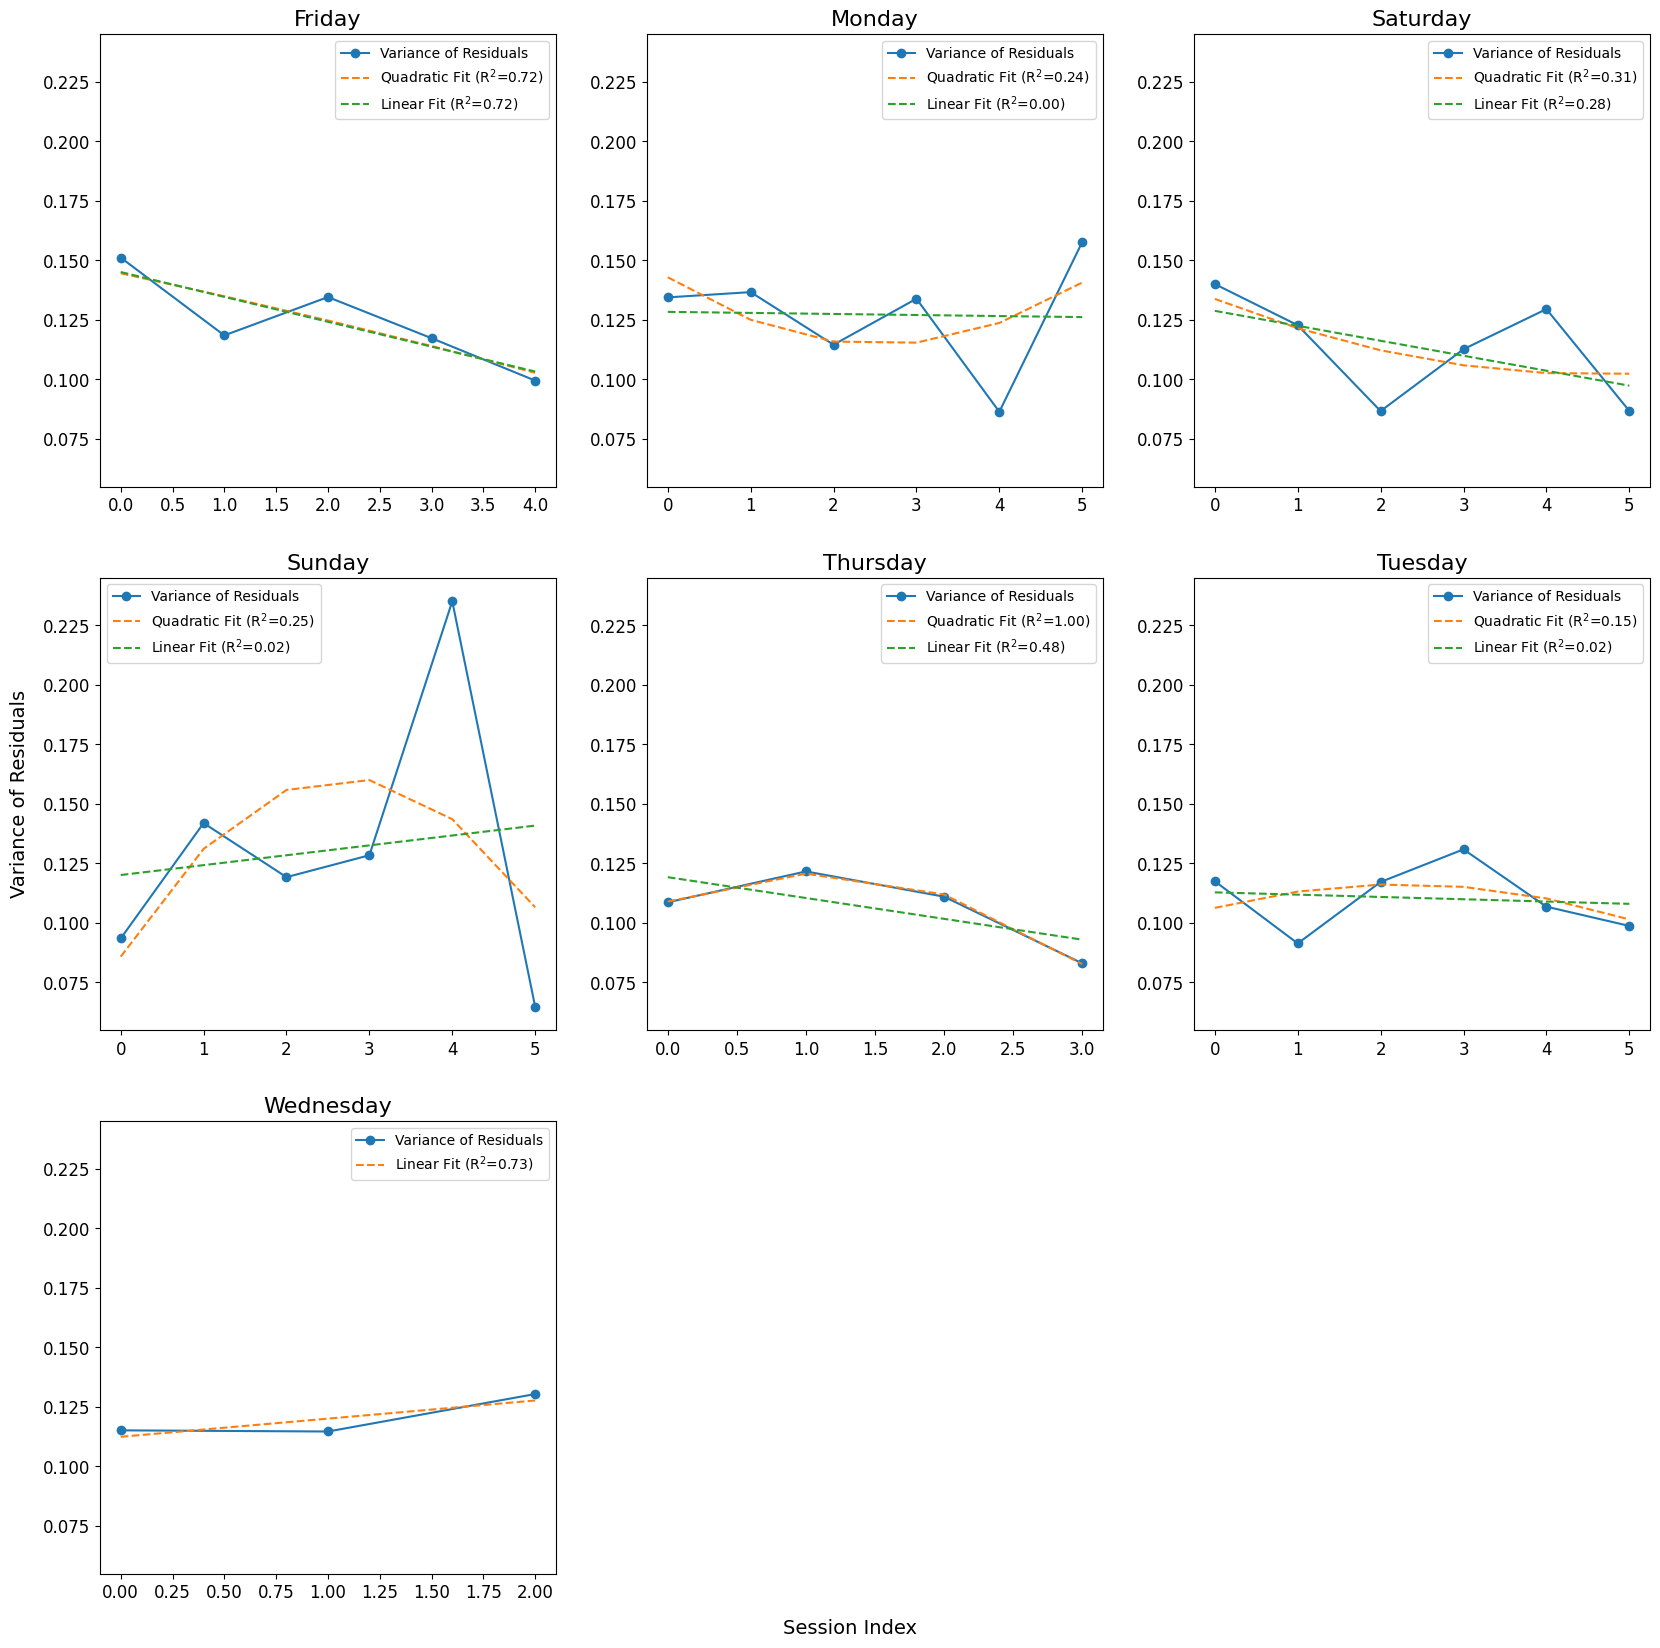

In [85]:
# Create figure with subplots for variance and edgewise residuals
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
min_res_var = 1000
max_res_var = 0
for i, (day_of_week, group) in enumerate(residuals_df.groupby('day_of_week')):
    plt.sca(axes[i // 3, i % 3])
    res = group.drop(columns=['session', 'day_of_week', 'time_of_day','pe_dir']).values.T
    min_res_var, max_res_var = plot_res_variance(res, groupedby=day_of_week, min_res_var=min_res_var, max_res_var=max_res_var)

#Set same y-axis limits for all subplots
for ax in axes.flat:
    ax.set_ylim(min_res_var-0.01, max_res_var+0.01)
    
# Hide the last two subplots (axes[2, 1] and axes[2, 2])
axes[2, 1].axis('off')
axes[2, 2].axis('off')
fig.text(0.5, 0.08, 'Session Index', ha='center', fontsize=14)
fig.text(0.08, 0.5, 'Variance of Residuals', va='center', rotation='vertical', fontsize=14)
plt.show()

/usr/local/fsl/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


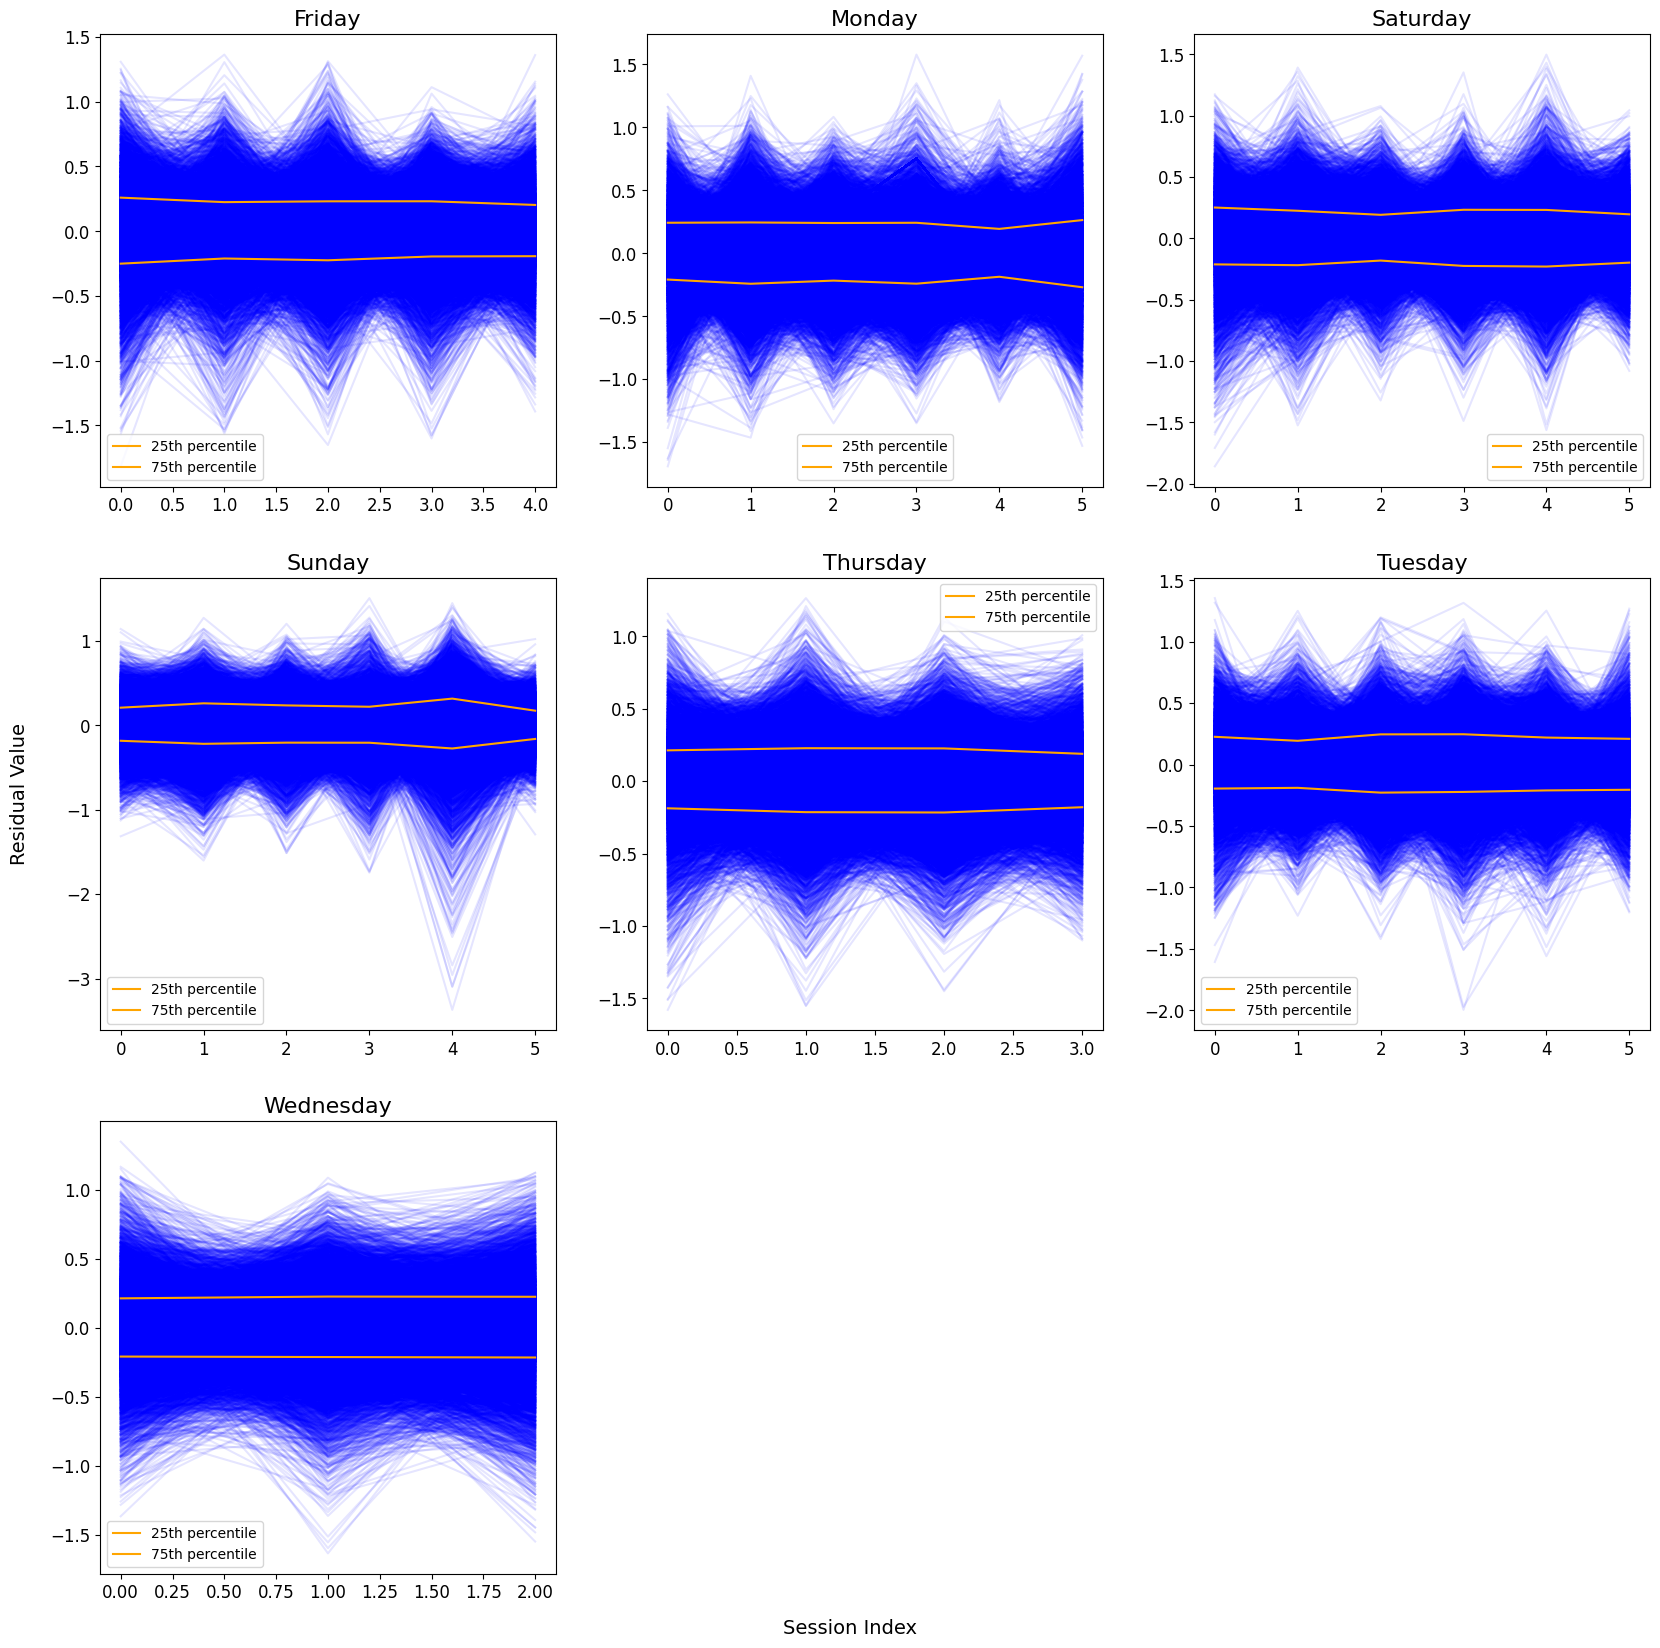

In [86]:
# Create figure with subplots for variance and edgewise residuals
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
for i, (day_of_week, group) in enumerate(residuals_df.groupby('day_of_week')):
    plt.sca(axes[i // 3, i % 3])
    res = group.drop(columns=['session', 'day_of_week', 'time_of_day','pe_dir']).values.T
    plot_edgewise_residual(res, groupedby=day_of_week)
# Hide the last two subplots (axes[2, 1] and axes[2, 2])
axes[2, 1].axis('off')
axes[2, 2].axis('off')
fig.text(0.5, 0.08, 'Session Index', ha='center', fontsize=14)
fig.text(0.08, 0.5, 'Residual Value', va='center', rotation='vertical', fontsize=14)
plt.show()

## Time of day

Time of day: 09:00:00
(8257, 1)
Time of day: 10:00:00
(8257, 2)
Time of day: 11:00:00
(8257, 2)
Time of day: 12:00:00
(8257, 3)
Time of day: 18:00:00
(8257, 2)
Time of day: 19:00:00
(8257, 2)
Time of day: 20:00:00
(8257, 11)
Time of day: 21:00:00
(8257, 5)
Time of day: 22:00:00
(8257, 7)
Time of day: 23:00:00
(8257, 1)


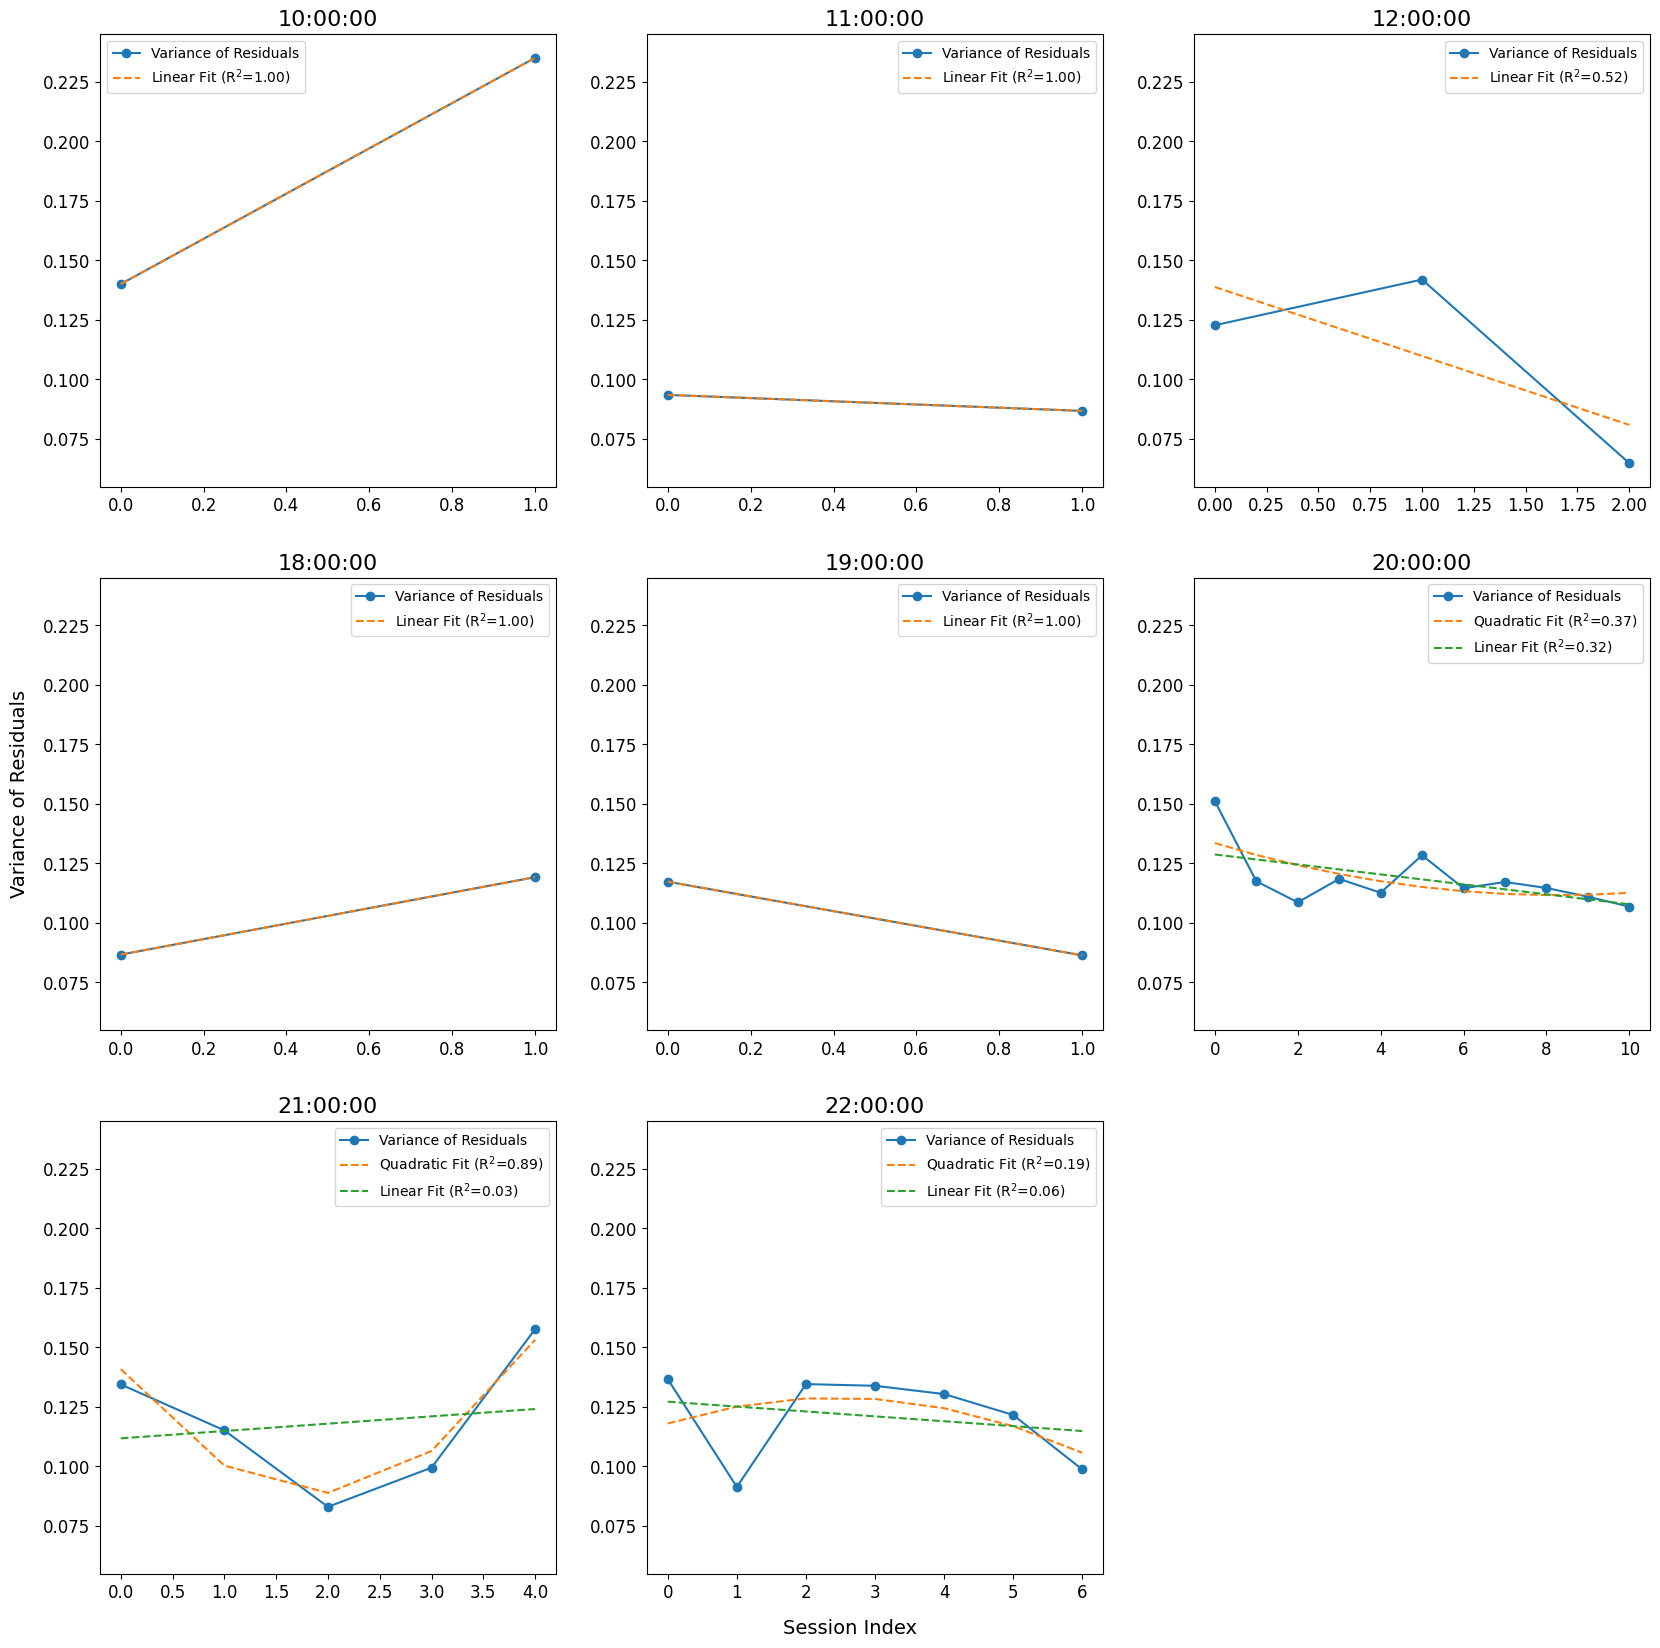

In [87]:
# Create figure with subplots for variance and edgewise residuals
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
min_res_var = 1000
max_res_var = 0
i = 0
for time_of_day, group in residuals_df.groupby('time_of_day'):
    print("Time of day:", time_of_day)
    plt.sca(axes[i // 3, i % 3])
    res = group.drop(columns=['session', 'day_of_week', 'time_of_day','pe_dir']).values.T
    print(res.shape)
    if res.shape[1] > 1:
        min_res_var, max_res_var = plot_res_variance(res, groupedby=time_of_day, min_res_var=min_res_var, max_res_var=max_res_var)
        i += 1

#Set same y-axis limits for all subplots
for ax in axes.flat:
    ax.set_ylim(min_res_var-0.01, max_res_var+0.01)

 # Hide the last axis
axes[2, 2].axis('off')
fig.text(0.5, 0.08, 'Session Index', ha='center', fontsize=14)
fig.text(0.08, 0.5, 'Variance of Residuals', va='center', rotation='vertical', fontsize=14)
plt.show()

Time of day: 09:00:00
(8257, 1)
Time of day: 10:00:00
(8257, 2)
Time of day: 11:00:00
(8257, 2)
Time of day: 12:00:00
(8257, 3)
Time of day: 18:00:00
(8257, 2)
Time of day: 19:00:00
(8257, 2)
Time of day: 20:00:00
(8257, 11)
Time of day: 21:00:00
(8257, 5)
Time of day: 22:00:00
(8257, 7)
Time of day: 23:00:00
(8257, 1)


/usr/local/fsl/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


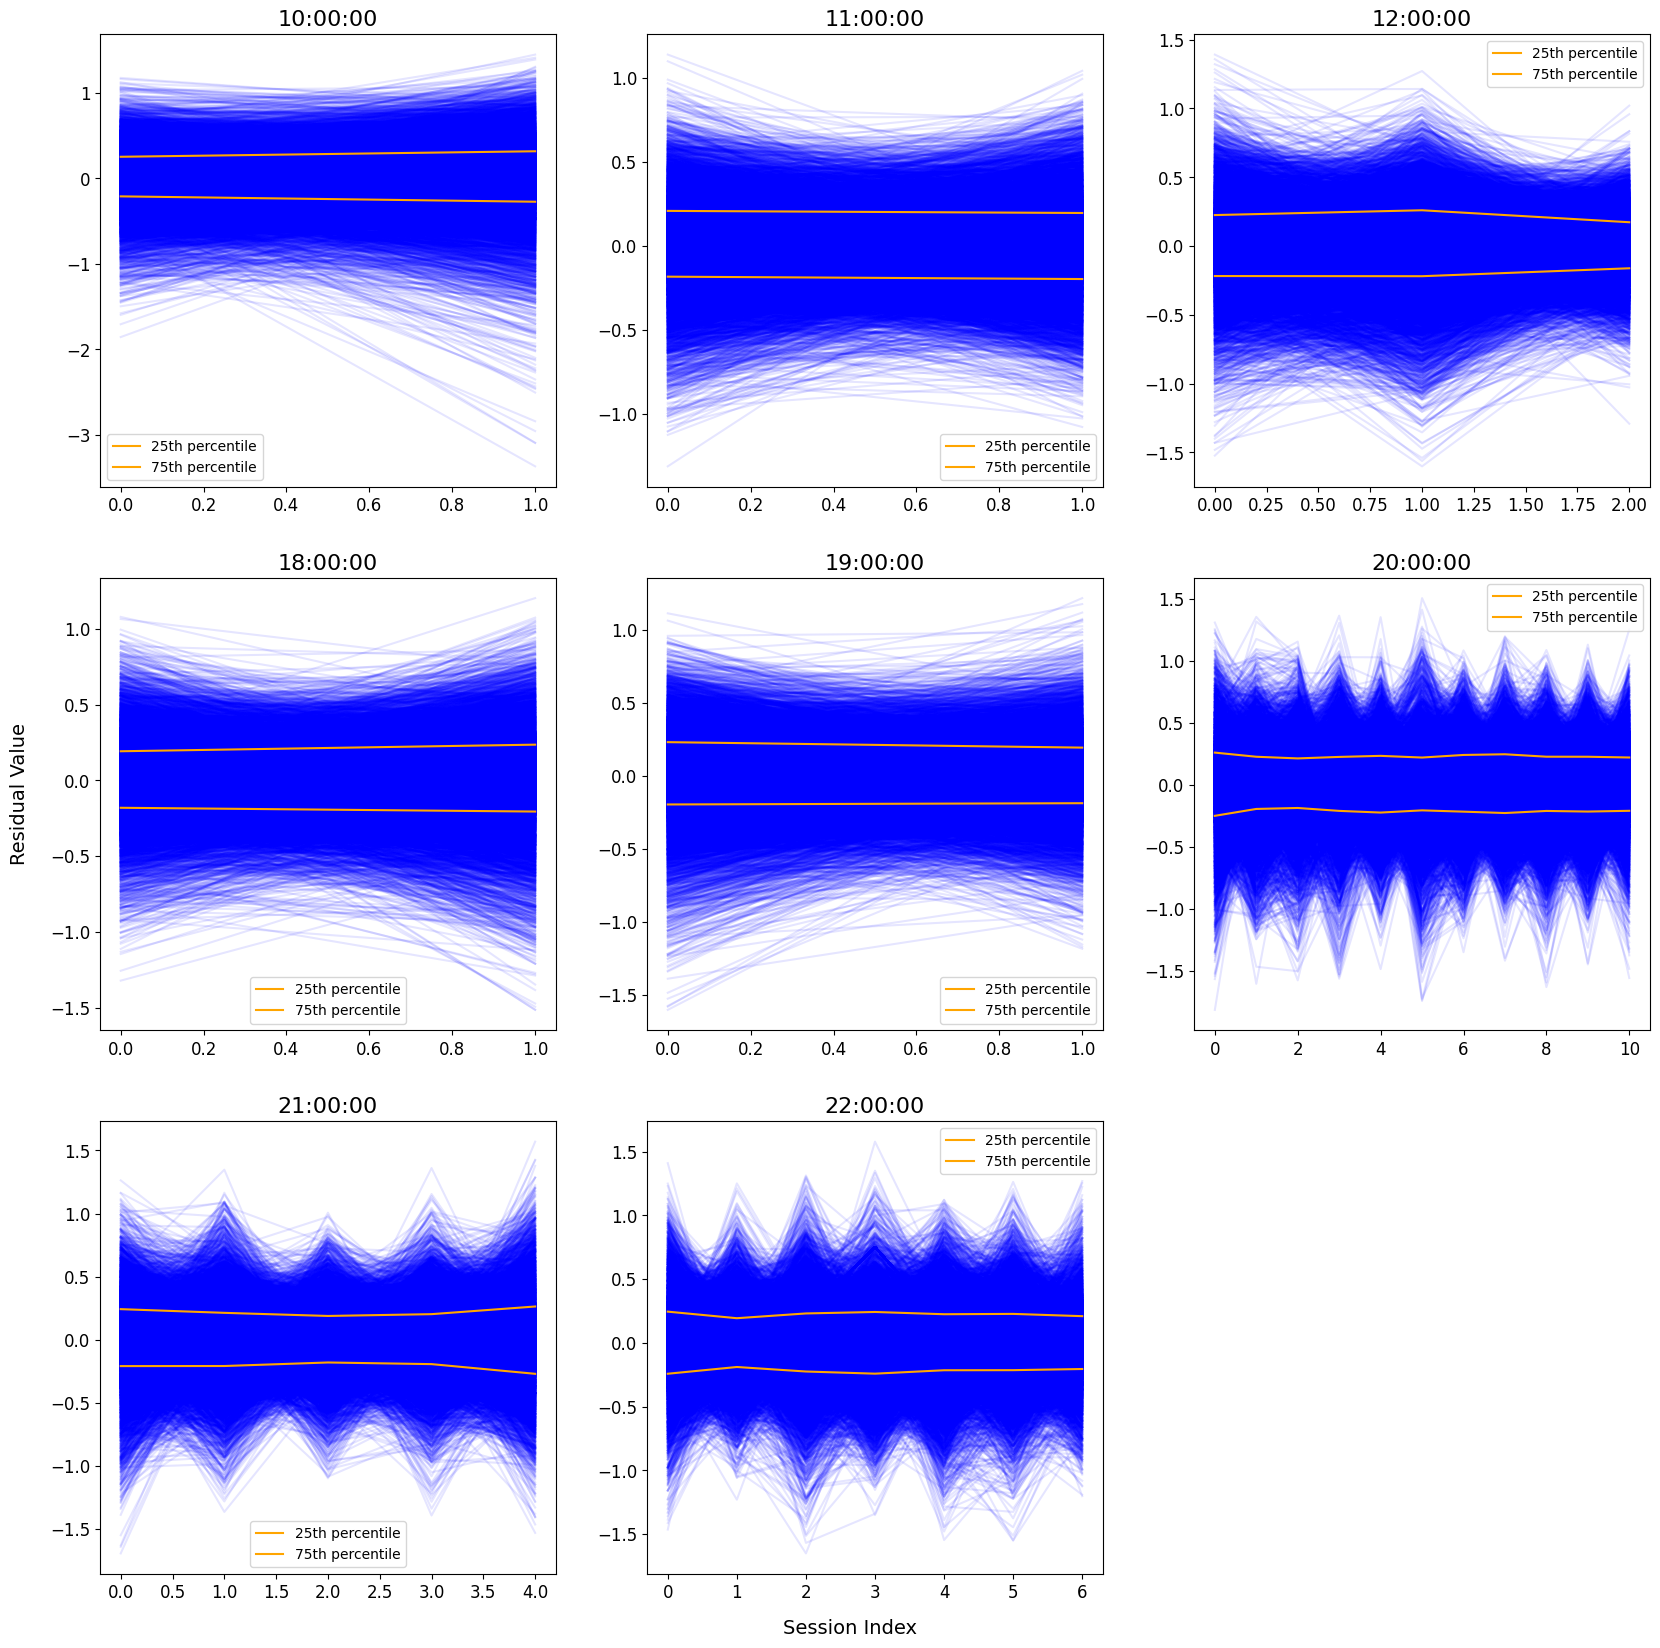

In [88]:
# Create figure with subplots for variance and edgewise residuals
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
min_res_var = 1000
max_res_var = 0
i = 0
for time_of_day, group in residuals_df.groupby('time_of_day'):
    print("Time of day:", time_of_day)
    plt.sca(axes[i // 3, i % 3])
    res = group.drop(columns=['session', 'day_of_week', 'time_of_day','pe_dir']).values.T
    print(res.shape)
    if res.shape[1] > 1:
        plot_edgewise_residual(res, groupedby=time_of_day)
        i += 1

 # Hide the last axis
axes[2, 2].axis('off')
fig.text(0.5, 0.08, 'Session Index', ha='center', fontsize=14)
fig.text(0.08, 0.5, 'Residual Value', va='center', rotation='vertical', fontsize=14)
plt.show()

## Phase Encoding Direction

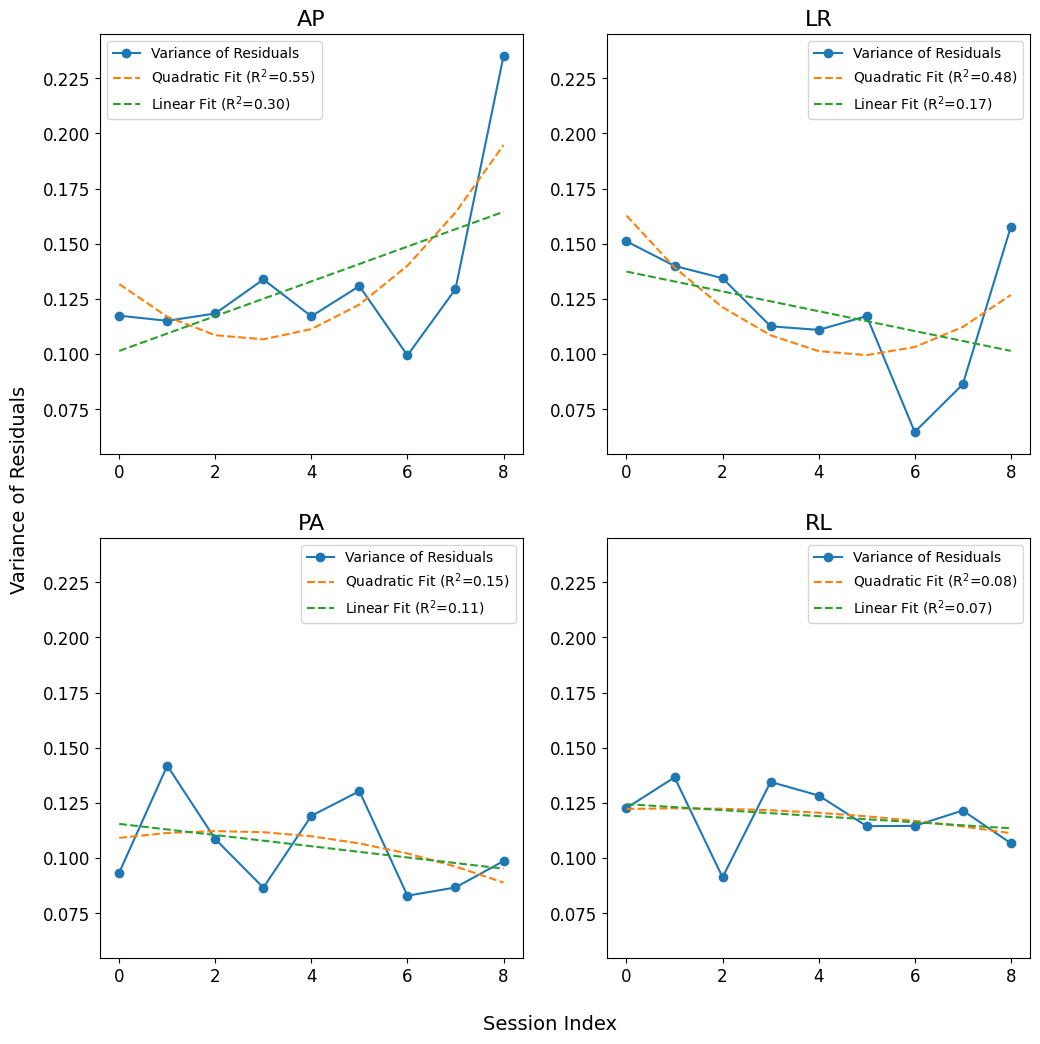

In [89]:
# Create figure with subplots for variance and edgewise residuals
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
min_res_var = 1000
max_res_var = 0
for i, (pe_dir, group) in enumerate(residuals_df.groupby('pe_dir')):
    plt.sca(axes[i // 2, i % 2])
    res = group.drop(columns=['session', 'day_of_week', 'time_of_day','pe_dir']).values.T
    min_res_var, max_res_var = plot_res_variance(res, groupedby=pe_dir, min_res_var=min_res_var, max_res_var=max_res_var)

#Set same y-axis limits for all subplots
for ax in axes.flat:
    ax.set_ylim(min_res_var-0.01, max_res_var+0.01)

fig.text(0.5, 0.05, 'Session Index', ha='center', fontsize=14)
fig.text(0.05, 0.5, 'Variance of Residuals', va='center', rotation='vertical', fontsize=14)
plt.show()

/usr/local/fsl/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


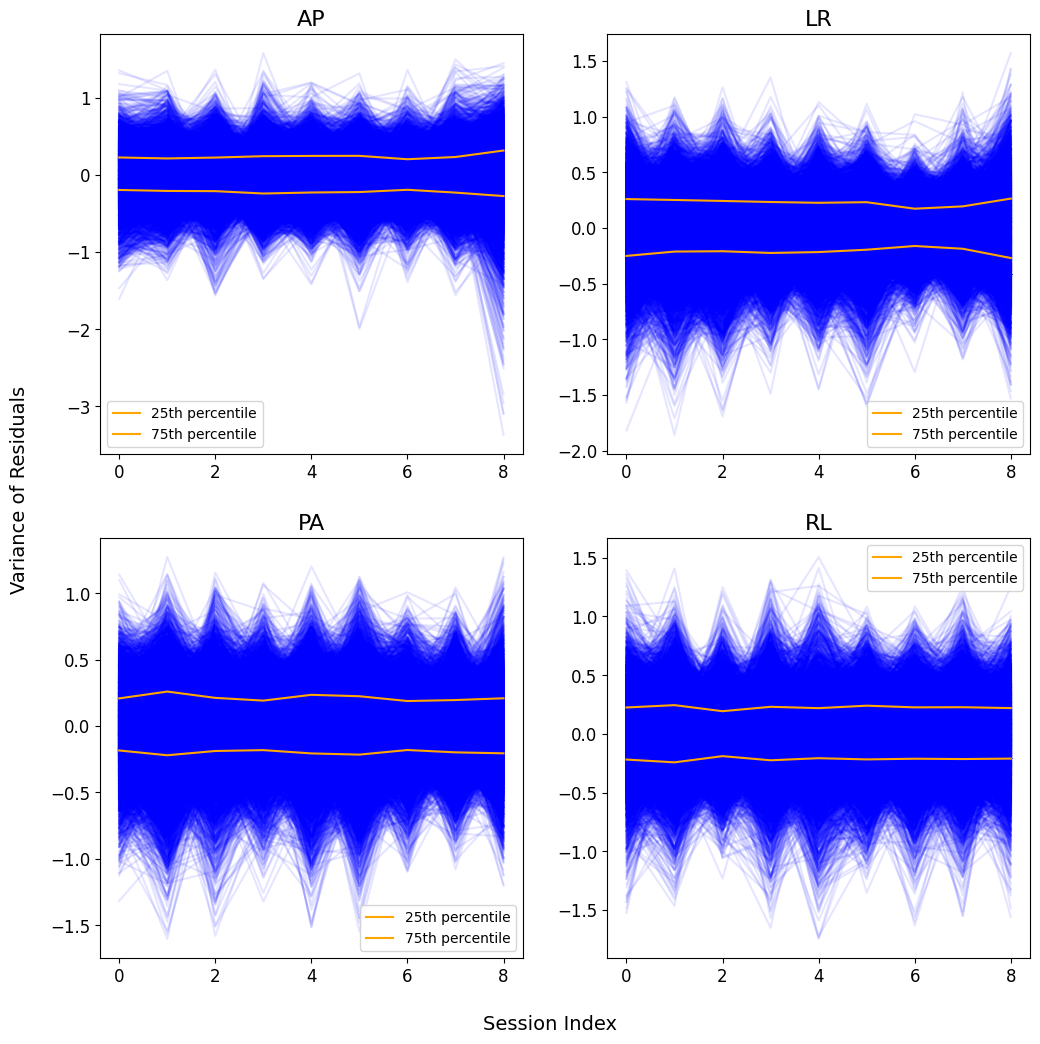

In [90]:
# Create figure with subplots for variance and edgewise residuals
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
min_res_var = 1000
max_res_var = 0
for i, (pe_dir, group) in enumerate(residuals_df.groupby('pe_dir')):
    plt.sca(axes[i // 2, i % 2])
    res = group.drop(columns=['session', 'day_of_week', 'time_of_day','pe_dir']).values.T
    plot_edgewise_residual(res, groupedby=pe_dir)

fig.text(0.5, 0.05, 'Session Index', ha='center', fontsize=14)
fig.text(0.05, 0.5, 'Variance of Residuals', va='center', rotation='vertical', fontsize=14)
plt.show()